In [2]:
import gzip
from Bio import SeqIO, SeqRecord
from Bio.SeqUtils.CodonUsage import CodonAdaptationIndex
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import re
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
from datetime import datetime
import random

human_proteome_path = "../../datasets/raw/Homo_sapiens.GRCh38.cds.all.fa.gz"
base_path = "../../datasets/raw/spike_nuc_X.fasta.gz"
paths = []

pattern = re.compile("[^AatTgGcC*?]")

for i in range(0, 15):
    path = base_path.replace("X", str(i+1))
    paths.append(path)

def is_gene_valid(seq):
    if len(seq) % 3 != 0:
        return False
    if re.search(pattern, str(seq)):
        return False
    
    return True

/home/dominik/miniconda3/envs/spike_rna/lib/python3.11/site-packages/Bio/SeqUtils/CodonUsageIndices.py:16: BiopythonDeprecationWarning: This module has been DEPRECATED. Please use the CodonAdaptationIndex class in Bio.SeqUtils instead. Note that this class has been updated to use modern Python, and may give slightly different results from the CodonAdaptationIndex class in Bio.SeqUtils.CodonUsage, as the code was changed to be consistent with the published paper by Sharp and Li. The code in the old CodonAdaptationIndex class in Bio.SeqUtils.CodonUsage was not changed.
  warnings.warn(
/home/dominik/miniconda3/envs/spike_rna/lib/python3.11/site-packages/Bio/SeqUtils/CodonUsage.py:15: BiopythonDeprecationWarning: This module has been DEPRECATED. Please use the CodonAdaptationIndex class in Bio.SeqUtils instead. Note that this class has been updated to use modern Python, and may give slightly different results from the CodonAdaptationIndex class in Bio.SeqUtils.CodonUsage, as the code was 

Length analysis

In [3]:
lens = []
outliers = 0
for path in paths:
    with gzip.open(path, "rt") as handle:
        for seq_record in tqdm(SeqIO.parse(handle, "fasta")):
            lens.append(len(seq_record.seq))

            if len(seq_record.seq) > 3796 or len(seq_record.seq) < 3796:
                # print(len(seq_record.seq))
                outliers += 1

            # if len(lens) > 100:
            #     break

1000000it [00:20, 48118.64it/s]
1000000it [00:20, 49937.06it/s]
1000000it [00:21, 46355.28it/s]
1000000it [00:20, 47912.82it/s]
1000000it [00:21, 45512.06it/s]
1000000it [00:21, 45962.88it/s]
1000000it [00:21, 47374.90it/s]
1000000it [00:20, 47877.61it/s]
1000000it [00:21, 47468.58it/s]
1000000it [00:21, 47173.97it/s]
1000000it [00:20, 48479.45it/s]
1000000it [00:20, 47705.59it/s]
1000000it [00:20, 48073.12it/s]
1000000it [00:20, 48485.02it/s]
1000000it [00:21, 47234.72it/s]


In [15]:
unique, counts = np.unique(lens, return_counts=True)
counts = counts/len(lens)
lengths = dict(zip(unique, counts))
lengths = dict(sorted(lengths.items(), key=lambda item: item[1], reverse=True))
# print(lengths)

i = 0
cumulative = 0
for key in lengths.keys():
    
    cumulative += lengths.get(key)
    print(str(key) + " (" + str(lengths.get(key)) + "%) cumulative = " + str(cumulative))
    i += 1
    if i == 35:
        break
# print(cumulative)

3813 (0.3580504%) cumulative = 0.3580504
3816 (0.2838652%) cumulative = 0.6419155999999999
3807 (0.15410213333333334%) cumulative = 0.7960177333333333
3822 (0.14248806666666666%) cumulative = 0.9385058
3804 (0.0202782%) cumulative = 0.958784
3810 (0.0073426%) cumulative = 0.9661266
3819 (0.005445%) cumulative = 0.9715716
2508 (0.004880133333333333%) cumulative = 0.9764517333333333
2502 (0.0040058%) cumulative = 0.9804575333333333
3814 (0.002319%) cumulative = 0.9827765333333333
2511 (0.0017469333333333334%) cumulative = 0.9845234666666666
3825 (0.0016505333333333334%) cumulative = 0.9861739999999999
3808 (0.001526%) cumulative = 0.9876999999999999
3801 (0.0012116%) cumulative = 0.9889115999999999
3831 (0.0011456666666666666%) cumulative = 0.9900572666666666
3821 (0.0006939333333333334%) cumulative = 0.9907511999999999
3828 (0.0006695333333333333%) cumulative = 0.9914207333333332
3817 (0.0005036%) cumulative = 0.9919243333333333
3820 (0.00048706666666666667%) cumulative = 0.992411399999

14999805
15000000
(3794.7322727998735, 3794.910139066793)


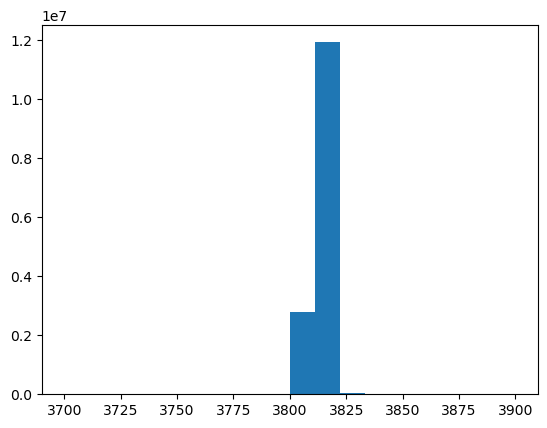

In [12]:


print(outliers)
print(len(lens))
# print(max(set(lens), key=lens.count))
# print(lens.count(max(set(lens), key=lens.count)))
print(st.t.interval(confidence=0.95, df=len(lens)-1, loc=np.mean(lens), scale=st.sem(lens)) )
plt.hist(lens, bins=18, range=(3700, 3900))
plt.show() 



In [21]:
lens = {}
for path in paths:
    with open(path, "r") as handle:
        for seq_record in tqdm(SeqIO.parse(handle, "fasta")):
            if len(seq_record.seq) in lens:
                lens[len(seq_record.seq)] += 1
            else:
                lens[len(seq_record.seq)] = 0


            # if len(lens) > 100:
            #     break

            # if len(seq_record.seq) > 3796 or len(seq_record.seq) < 3796:
            #     # print(len(seq_record.seq))
            #     outliers += 1

lens_pd = pd.DataFrame.from_dict(lens, orient='index')
lens_pd.columns = ["num"]
lens_pd.sort_values(by = ['num'],inplace=True, ascending=False)
print(lens_pd)
# print(outliers)
# print(len(lens))
# # print(max(set(lens), key=lens.count))
# # print(lens.count(max(set(lens), key=lens.count)))
# print(st.t.interval(confidence=0.95, df=len(lens)-1, loc=np.mean(lens), scale=st.sem(lens)) )
# plt.hist(lens, bins=18, range=(3804, 3821))
# plt.show() 


750709it [00:08, 88710.62it/s]
725577it [00:08, 87661.83it/s]
628270it [00:07, 88038.72it/s]
614948it [00:07, 87763.17it/s]
732090it [00:08, 86320.61it/s]
643698it [00:07, 85661.33it/s]
609836it [00:07, 84996.97it/s]
504512it [00:05, 84713.90it/s]
542315it [00:06, 85238.39it/s]
638398it [00:07, 84652.94it/s]
612798it [00:07, 82839.12it/s]
680992it [00:07, 88491.35it/s]
688620it [00:07, 87783.79it/s]
707153it [00:08, 85762.17it/s]
689719it [00:08, 85438.88it/s]

          num
3813  3640315
3816  2986779
3807  1650426
3822  1054342
3804   153115
...       ...
1476        0
1896        0
1938        0
1870        0
1487        0

[2681 rows x 1 columns]


In [17]:
lens = []
outliers = 0
for path in paths:
    with open(path, "r") as handle:
        for seq_record in tqdm(SeqIO.parse(handle, "fasta")):
            if len(seq_record.seq) == 3813:
                # print(len(seq_record.seq))
                lens.append(seq_record.seq)

            # if len(lens) > 100:
            #     break

print(outliers)
print(len(lens))


750709it [00:09, 76270.30it/s]
725577it [00:09, 74603.86it/s]
628270it [00:07, 80311.14it/s]
614948it [00:07, 79168.51it/s]
732090it [00:09, 80522.85it/s]
643698it [00:08, 76909.45it/s]
609836it [00:07, 81396.54it/s]
504512it [00:06, 76660.21it/s]
542315it [00:08, 66792.45it/s]
638398it [00:08, 74182.73it/s]
612798it [00:08, 72290.53it/s]
680992it [00:10, 64250.35it/s]
688620it [00:08, 77754.26it/s]
707153it [00:08, 79436.43it/s]
689719it [00:08, 80004.84it/s]

0
3640316


In [18]:
print(len(lens))
print(len(set(lens)))

3640316
208236


Codon bias analysis

In [2]:
human_proteome = SeqIO.parse(gzip.open(human_proteome_path, "rt"), "fasta")
human_valid_proteome = []
for seq_record in tqdm(human_proteome):
    if is_gene_valid(seq_record.seq):
        human_valid_proteome.append(seq_record)
human_bias = CodonAdaptationIndex(human_valid_proteome)
print(human_bias)




121766it [00:02, 57116.24it/s]


AAA	0.804
AAC	1.000
AAG	1.000
AAT	0.946
ACA	0.859
ACC	1.000
ACG	0.317
ACT	0.741
AGA	1.000
AGC	1.000
AGG	0.944
AGT	0.668
ATA	0.384
ATC	1.000
ATG	1.000
ATT	0.822
CAA	0.372
CAC	1.000
CAG	1.000
CAT	0.772
CCA	0.921
CCC	1.000
CCG	0.340
CCT	0.962
CGA	0.513
CGC	0.762
CGG	0.895
CGT	0.372
CTA	0.191
CTC	0.491
CTG	1.000
CTT	0.367
GAA	0.790
GAC	1.000
GAG	1.000
GAT	0.935
GCA	0.623
GCC	1.000
GCG	0.253
GCT	0.706
GGA	0.819
GGC	1.000
GGG	0.761
GGT	0.527
GTA	0.277
GTC	0.520
GTG	1.000
GTT	0.426
TAA	0.516
TAC	1.000
TAG	0.401
TAT	0.857
TCA	0.678
TCC	0.906
TCG	0.220
TCT	0.818
TGA	1.000
TGC	1.000
TGG	1.000
TGT	0.889
TTA	0.213
TTC	1.000
TTG	0.349
TTT	0.913



In [3]:
covid_biases = []

for path in paths:
    all = []
    i = 0
    with open(path, "r") as handle:
        for seq_record in tqdm(SeqIO.parse(path, "fasta")):
            all.append(seq_record)

        for seq in tqdm(random.sample(all, 10000)):
            if is_gene_valid(seq.seq):
                bias = CodonAdaptationIndex([seq])
                bias["date"] = seq.description.split("|")[2]
                try:
                    datetime.strptime(bias["date"], "%Y-%m-%d")
                    covid_biases.append(bias)
                    i+=1
                except ValueError:
                    # print(bias["date"])
                    continue
# for path in paths:
#     i = 0
#     with open(path, "r") as handle:
#         for seq_record in tqdm(SeqIO.parse(path, "fasta")):
#             if is_gene_valid(seq_record.seq):
#                 bias = CodonAdaptationIndex([seq_record])
#                 bias["date"] = seq_record.description.split("|")[2]
#                 try:
#                     datetime.strptime(bias["date"], "%Y-%m-%d")
#                     covid_biases.append(bias)
#                     i+=1
#                 except ValueError:
#                     # print(bias["date"])
#                     continue
#             if i > 10000:
#                 break
    

# print(covid_biases[0].items())

750709it [00:11, 65866.18it/s]
100%|██████████| 10000/10000 [00:13<00:00, 765.11it/s]
725577it [00:10, 71665.59it/s]
100%|██████████| 10000/10000 [00:12<00:00, 797.27it/s]
628270it [00:09, 68891.69it/s]
100%|██████████| 10000/10000 [00:12<00:00, 823.49it/s]
614948it [00:08, 70472.04it/s]
100%|██████████| 10000/10000 [00:12<00:00, 807.28it/s]
732090it [00:10, 69623.43it/s]
100%|██████████| 10000/10000 [00:13<00:00, 760.44it/s]
643698it [00:09, 71483.09it/s]
100%|██████████| 10000/10000 [00:12<00:00, 779.15it/s]
609836it [00:08, 69837.87it/s]
100%|██████████| 10000/10000 [00:12<00:00, 779.49it/s]
504512it [00:07, 68052.76it/s]
100%|██████████| 10000/10000 [00:12<00:00, 772.99it/s]
542315it [00:07, 67927.55it/s]
100%|██████████| 10000/10000 [00:12<00:00, 772.90it/s]
638398it [00:09, 69783.47it/s]
100%|██████████| 10000/10000 [00:12<00:00, 809.28it/s]
612798it [00:08, 72327.14it/s]
100%|██████████| 10000/10000 [00:12<00:00, 802.49it/s]
680992it [00:10, 66301.99it/s]
100%|██████████| 10000/

             pc0       pc1  date   type
140004  0.022923 -0.030832   914  covid
140005  0.034210 -0.037468  1080  covid
140006  0.022923 -0.030832  1029  covid
140007  0.253265 -0.780313  1089  covid
0       2.408112  0.982866    -1  human


/home/dominik/miniconda3/envs/spike_rna/lib/python3.11/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'PCA analysis of CAI')]

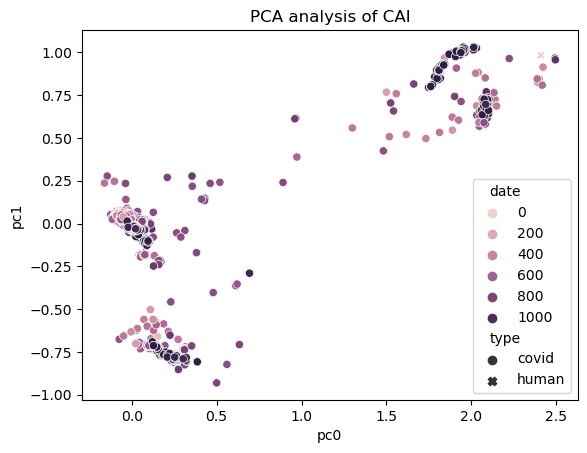

In [7]:
def days(d):
    return d.days

all_biases = covid_biases + [human_bias]
all_biases_pd = pd.DataFrame(all_biases)
covid_biases_pd = pd.DataFrame(covid_biases)
human_bias_pd = pd.DataFrame([human_bias])
# print(all_biases_pd.head())
# print(all_biases_pd.tail())

covid_biases_pd["date"] = pd.to_datetime(covid_biases_pd["date"], format="%Y-%m-%d")
covid_biases_pd["date"] = (covid_biases_pd["date"] - min(covid_biases_pd["date"]))
dates = covid_biases_pd["date"].apply(days)
covid_biases_pd.drop(columns=["date"], inplace=True)

pca = PCA(n_components=2)

pca.fit(all_biases_pd.drop(columns=["date"], inplace=False))

covid_biases_pd = pca.transform(covid_biases_pd)
human_bias_pd = pca.transform(human_bias_pd)

covid_biases_pd = pd.DataFrame(covid_biases_pd, columns=["pc0", "pc1"])
covid_biases_pd["date"] = dates
covid_biases_pd["type"] = "covid"

human_bias_pd = pd.DataFrame(human_bias_pd, columns=["pc0", "pc1"])
human_bias_pd["date"] = -1
human_bias_pd["type"] = "human"

all_biases_pd = pd.concat([covid_biases_pd, human_bias_pd])
print(all_biases_pd.tail())

sns.scatterplot(all_biases_pd["pc0"], all_biases_pd["pc1"], hue=all_biases_pd["date"], style=all_biases_pd["type"]).set(title='PCA analysis of CAI')

# sns.kdeplot(
#     data=all_biases_pd, x="pc0", y="1", hue="pc1", fill=True,
# )



In [6]:
print(pca.explained_variance_ratio_)

[0.2739754  0.22894138]


In [139]:
def days(d):
    return d.days

all_biases = covid_biases + [human_bias]
all_biases_pd = pd.DataFrame(all_biases)
covid_biases_pd = pd.DataFrame(covid_biases)
human_bias_pd = pd.DataFrame([human_bias])
# print(all_biases_pd.head())
# print(all_biases_pd.tail())

covid_biases_pd["date"] = pd.to_datetime(covid_biases_pd["date"], format="%Y-%m-%d")
covid_biases_pd["date"] = (covid_biases_pd["date"] - min(covid_biases_pd["date"]))
dates = covid_biases_pd["date"].apply(days)
covid_biases_pd.drop(columns=["date"], inplace=True)

pca = PCA(n_components=2)

pca.fit(all_biases_pd.drop(columns=["date"], inplace=False))

covid_biases_pd = pca.transform(covid_biases_pd)
human_bias_pd = pca.transform(human_bias_pd)

covid_biases_pd = pd.DataFrame(covid_biases_pd, columns=["pc0", "pc1"])
covid_biases_pd["date"] = dates
covid_biases_pd["type"] = "covid"

human_bias_pd = pd.DataFrame(human_bias_pd, columns=["pc0", "pc1"])
human_bias_pd["date"] = -1
human_bias_pd["type"] = "human"

all_biases_pd = pd.concat([covid_biases_pd, human_bias_pd])
print(all_biases_pd.tail())

all_biases_pd.reset_index(inplace=True)
all_biases_pd["date"] = all_biases_pd["date"] // 300

sns.kdeplot(
    data=all_biases_pd, x="pc0", y="pc1", hue="date", thresh=0.000005
)

             pc0       pc1  date   type
140114  0.032881 -0.017880  1042  covid
140115  0.036412 -0.014474  1049  covid
140116 -0.050086  0.043462   591  covid
140117  0.038677 -0.012975  1090  covid
0       2.104709  1.343977    -1  human


/tmp/ipykernel_9016/2818809324.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_biases_pd_early["type"] = "early covid"
/tmp/ipykernel_9016/2818809324.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_biases_pd_early["type"] = "late covid"


ValueError: Contour levels must be increasing

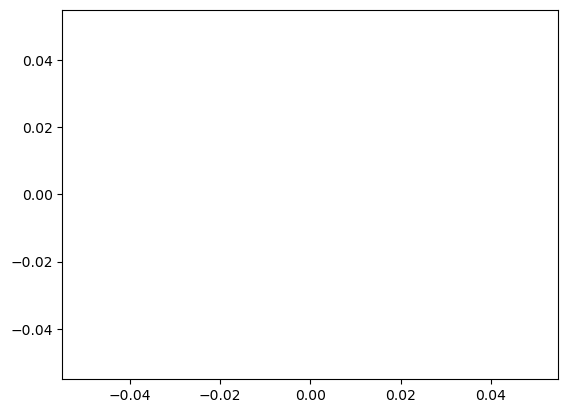

In [178]:
def days(d):
    return d.days

all_biases = covid_biases + [human_bias]
all_biases_pd = pd.DataFrame(all_biases)
covid_biases_pd = pd.DataFrame(covid_biases)
human_bias_pd = pd.DataFrame([human_bias])
# print(all_biases_pd.head())
# print(all_biases_pd.tail())

covid_biases_pd["date"] = pd.to_datetime(covid_biases_pd["date"], format="%Y-%m-%d")
covid_biases_pd["date"] = (covid_biases_pd["date"] - min(covid_biases_pd["date"]))
dates = covid_biases_pd["date"].apply(days)
covid_biases_pd.drop(columns=["date"], inplace=True)

pca = PCA(n_components=2)

pca.fit(all_biases_pd.drop(columns=["date"], inplace=False))

covid_biases_pd = pca.transform(covid_biases_pd)
human_bias_pd = pca.transform(human_bias_pd)

covid_biases_pd = pd.DataFrame(covid_biases_pd, columns=["pc0", "pc1"])
covid_biases_pd["date"] = dates
covid_biases_pd["type"] = "covid"

human_bias_pd = pd.DataFrame(human_bias_pd, columns=["pc0", "pc1"])
human_bias_pd["date"] = -1
human_bias_pd["type"] = "human"

all_biases_pd = pd.concat([covid_biases_pd, human_bias_pd])
print(all_biases_pd.tail())

all_biases_pd.reset_index(inplace=True)
all_biases_pd_early = all_biases_pd.loc[all_biases_pd["date"] < 100]
all_biases_pd_early["type"] = "early covid"
all_biases_pd_late = all_biases_pd.loc[all_biases_pd["date"] > 1100]
all_biases_pd_early["type"] = "late covid"

all_biases_pd = pd.concat([all_biases_pd_early, all_biases_pd_early])
all_biases_pd.reset_index(inplace=True)

sns.kdeplot(
    data=all_biases_pd, x="pc0", y="pc1", hue="type", common_norm=False
)

/home/dominik/miniconda3/envs/spike_rna/lib/python3.11/site-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


<Axes: xlabel='pc0', ylabel='pc1'>

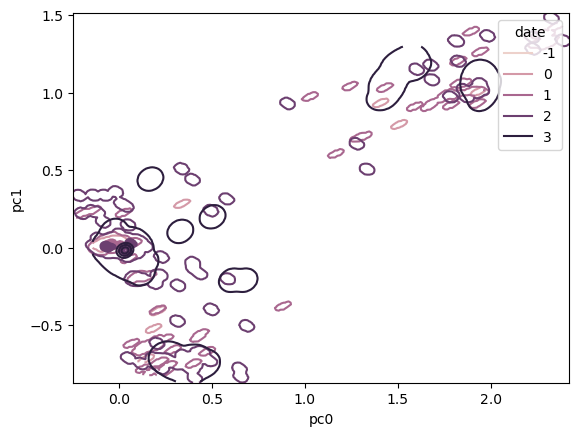

In [140]:
# all_biases_pd.reset_index(inplace=True)

# all_biases_pd["date"] = all_biases_pd["date"] // 100
# print(all_biases_pd.head())
# sns.displot(
#     data=all_biases_pd, x="pc0", y="pc1", hue="date",
# )

# sns.histplot(
#     data=all_biases_pd, x="pc0", y="pc1", hue="date",bins=50, palette=sns.color_palette("tab10")[0:7]
# )
# sns.histplot(
#     data=all_biases_pd, x="pc0", y="pc1", hue="date",bins=50
# )

             pc0       pc1  date   type
140004  0.022923 -0.030832   914  covid
140005  0.034210 -0.037468  1080  covid
140006  0.022923 -0.030832  1029  covid
140007  0.253265 -0.780313  1089  covid
0       2.408112  0.982866    -1  human


[Text(0.5, 1.0, 'Histogram of timestamps')]

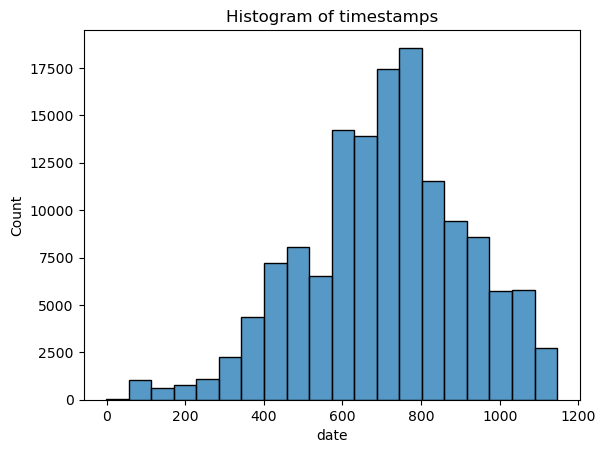

In [9]:
def days(d):
    return d.days

all_biases = covid_biases + [human_bias]
all_biases_pd = pd.DataFrame(all_biases)
covid_biases_pd = pd.DataFrame(covid_biases)
human_bias_pd = pd.DataFrame([human_bias])
# print(all_biases_pd.head())
# print(all_biases_pd.tail())

covid_biases_pd["date"] = pd.to_datetime(covid_biases_pd["date"], format="%Y-%m-%d")
covid_biases_pd["date"] = (covid_biases_pd["date"] - min(covid_biases_pd["date"]))
dates = covid_biases_pd["date"].apply(days)
covid_biases_pd.drop(columns=["date"], inplace=True)

pca = PCA(n_components=2)

pca.fit(all_biases_pd.drop(columns=["date"], inplace=False))

covid_biases_pd = pca.transform(covid_biases_pd)
human_bias_pd = pca.transform(human_bias_pd)

covid_biases_pd = pd.DataFrame(covid_biases_pd, columns=["pc0", "pc1"])
covid_biases_pd["date"] = dates
covid_biases_pd["type"] = "covid"

human_bias_pd = pd.DataFrame(human_bias_pd, columns=["pc0", "pc1"])
human_bias_pd["date"] = -1
human_bias_pd["type"] = "human"

all_biases_pd = pd.concat([covid_biases_pd, human_bias_pd])
print(all_biases_pd.tail())

all_biases_pd.reset_index(inplace=True)

sns.histplot(data=all_biases_pd, x="date", bins=20).set(title="Histogram of timestamps")

<class 'numpy.ndarray'>
        pc0  date   type
0  2.104709     0  human
1  2.104709     1  human
2  2.104709     2  human
3  2.104709     3  human
4  2.104709     4  human
9244
      index  date       pc0   type
2306   1195  1195  2.104709  human
2307   1196  1196  2.104709  human
2308   1197  1197  2.104709  human
2309   1198  1198  2.104709  human
2310   1199  1199  2.104709  human


<Axes: xlabel='date', ylabel='pc0'>

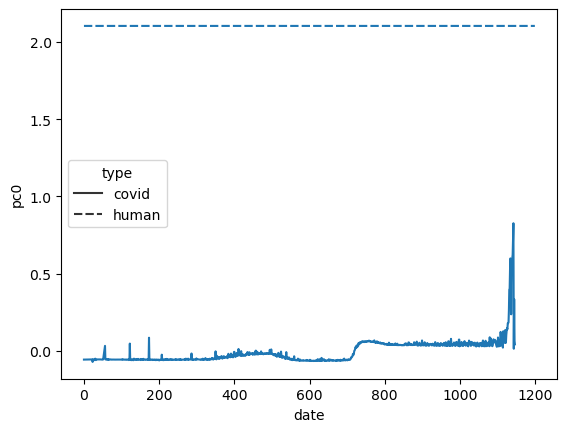

In [165]:
def days(d):
    return d.days

all_biases = covid_biases + [human_bias]
all_biases_pd = pd.DataFrame(all_biases)
covid_biases_pd = pd.DataFrame(covid_biases)
human_bias_pd = pd.DataFrame([human_bias])
# print(all_biases_pd.head())
# print(all_biases_pd.tail())

covid_biases_pd["date"] = pd.to_datetime(covid_biases_pd["date"], format="%Y-%m-%d")
covid_biases_pd["date"] = (covid_biases_pd["date"] - min(covid_biases_pd["date"]))
dates = covid_biases_pd["date"].apply(days)
covid_biases_pd.drop(columns=["date"], inplace=True)

pca = PCA(n_components=2)

pca.fit(all_biases_pd.drop(columns=["date"], inplace=False))

covid_biases_pd = pca.transform(covid_biases_pd)
human_bias_pd = pca.transform(human_bias_pd)

print(type(covid_biases_pd))

covid_biases_pd = pd.DataFrame(covid_biases_pd[:,0], columns=["pc0"])
covid_biases_pd["date"] = dates
covid_biases_pd = covid_biases_pd.groupby('date', as_index=False).mean()
covid_biases_pd["type"] = "covid"

human_bias_pd = pd.DataFrame(np.ones(1200) * human_bias_pd[0][0], columns=["pc0"])
human_bias_pd["date"] = range(0,1200)
human_bias_pd["type"] = "human"
print(human_bias_pd.head())

all_biases_pd = pd.concat([covid_biases_pd, human_bias_pd])
all_biases_pd.reset_index(inplace=True)

print(all_biases_pd.size)
print(all_biases_pd.tail())

sns.lineplot(data=all_biases_pd, x="date", y="pc0", style="type")

<class 'numpy.ndarray'>
        pc0  date   type
0  2.408112     0  human
1  2.408112     1  human
2  2.408112     2  human
3  2.408112     3  human
4  2.408112     4  human
564832
        index       pc0  date   type
141203   1195  2.408112  1195  human
141204   1196  2.408112  1196  human
141205   1197  2.408112  1197  human
141206   1198  2.408112  1198  human
141207   1199  2.408112  1199  human


[Text(0.5, 1.0, 'PCA 0 over time')]

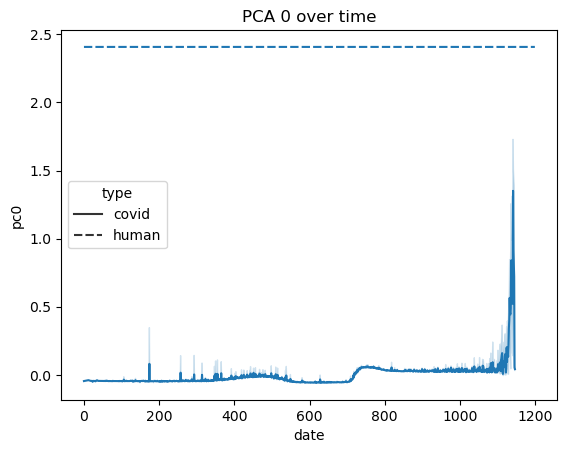

In [10]:
def days(d):
    return d.days

all_biases = covid_biases + [human_bias]
all_biases_pd = pd.DataFrame(all_biases)
covid_biases_pd = pd.DataFrame(covid_biases)
human_bias_pd = pd.DataFrame([human_bias])
# print(all_biases_pd.head())
# print(all_biases_pd.tail())

covid_biases_pd["date"] = pd.to_datetime(covid_biases_pd["date"], format="%Y-%m-%d")
covid_biases_pd["date"] = (covid_biases_pd["date"] - min(covid_biases_pd["date"]))
dates = covid_biases_pd["date"].apply(days)
covid_biases_pd.drop(columns=["date"], inplace=True)

pca = PCA(n_components=2)

pca.fit(all_biases_pd.drop(columns=["date"], inplace=False))

covid_biases_pd = pca.transform(covid_biases_pd)
human_bias_pd = pca.transform(human_bias_pd)

print(type(covid_biases_pd))

covid_biases_pd = pd.DataFrame(covid_biases_pd[:,0], columns=["pc0"])
covid_biases_pd["date"] = dates
covid_biases_pd["type"] = "covid"

human_bias_pd = pd.DataFrame(np.ones(1200) * human_bias_pd[0][0], columns=["pc0"])
human_bias_pd["date"] = range(0,1200)
human_bias_pd["type"] = "human"
print(human_bias_pd.head())

all_biases_pd = pd.concat([covid_biases_pd, human_bias_pd])
all_biases_pd.reset_index(inplace=True)

print(all_biases_pd.size)
print(all_biases_pd.tail())

sns.lineplot(data=all_biases_pd, x="date", y="pc0", style="type").set(title="PCA 0 over time")

<class 'numpy.ndarray'>
        pc0  date   type
0  2.408112     0  human
1  2.408112     1  human
2  2.408112     2  human
3  2.408112     3  human
4  2.408112     4  human
564832
        index       pc0  date   type
141203   1195  2.408112  1195  human
141204   1196  2.408112  1196  human
141205   1197  2.408112  1197  human
141206   1198  2.408112  1198  human
141207   1199  2.408112  1199  human


[Text(0.5, 1.0, 'PCA 0 over time scatterplot')]

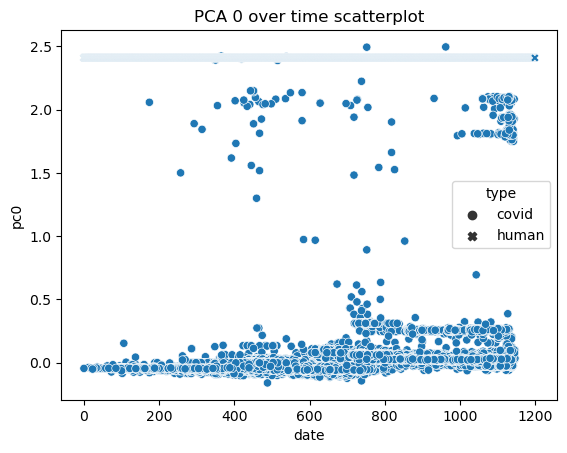

In [11]:
def days(d):
    return d.days

all_biases = covid_biases + [human_bias]
all_biases_pd = pd.DataFrame(all_biases)
covid_biases_pd = pd.DataFrame(covid_biases)
human_bias_pd = pd.DataFrame([human_bias])
# print(all_biases_pd.head())
# print(all_biases_pd.tail())

covid_biases_pd["date"] = pd.to_datetime(covid_biases_pd["date"], format="%Y-%m-%d")
covid_biases_pd["date"] = (covid_biases_pd["date"] - min(covid_biases_pd["date"]))
dates = covid_biases_pd["date"].apply(days)
covid_biases_pd.drop(columns=["date"], inplace=True)

pca = PCA(n_components=2)

pca.fit(all_biases_pd.drop(columns=["date"], inplace=False))

covid_biases_pd = pca.transform(covid_biases_pd)
human_bias_pd = pca.transform(human_bias_pd)

print(type(covid_biases_pd))

covid_biases_pd = pd.DataFrame(covid_biases_pd[:,0], columns=["pc0"])
covid_biases_pd["date"] = dates
covid_biases_pd["type"] = "covid"

human_bias_pd = pd.DataFrame(np.ones(1200) * human_bias_pd[0][0], columns=["pc0"])
human_bias_pd["date"] = range(0,1200)
human_bias_pd["type"] = "human"
print(human_bias_pd.head())

all_biases_pd = pd.concat([covid_biases_pd, human_bias_pd])
all_biases_pd.reset_index(inplace=True)

print(all_biases_pd.size)
print(all_biases_pd.tail())

sns.scatterplot(data=all_biases_pd, x="date", y="pc0", style="type").set(title="PCA 0 over time scatterplot")

In [5]:
unique = {}


for path in paths:
    all = []
    i = 0
    with open(path, "r") as handle:
        for seq_record in tqdm(SeqIO.parse(path, "fasta")):
            unique[seq_record.seq] = 1
    print(len(unique))

print(len(unique))

750709it [00:09, 78368.10it/s]


78093


725577it [00:09, 75418.32it/s]


136935


628270it [00:08, 74799.97it/s]


194432


614948it [00:08, 75465.69it/s]


257268


732090it [00:09, 75385.59it/s]


327993


643698it [00:08, 75765.44it/s]


387903


609836it [00:08, 74286.90it/s]


432918


504512it [00:06, 75595.55it/s]


471227


542315it [00:07, 73770.53it/s]


503149


638398it [00:08, 74950.09it/s]


540972


612798it [00:07, 77041.96it/s]


578470


680992it [00:09, 75454.09it/s]


629912


688620it [00:08, 77936.26it/s]


680562


707153it [00:09, 73019.96it/s]


749116


689719it [00:09, 72708.82it/s]

842202
842202
